<a href="https://colab.research.google.com/github/vanshaj1102/Ai-Agent-cookbook/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

# Deep learning (optional - uncomment if you have tensorflow)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

import kagglehub

In [9]:
print("Downloading Sentiment140 dataset...")
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Load the dataset
print("Loading dataset...")
# The Sentiment140 dataset has 6 columns: target, id, date, flag, user, text
# We'll focus on target (sentiment) and text columns
df = pd.read_csv(f"{path}/training.1600000.processed.noemoticon.csv",
                 encoding='ISO-8859-1',
                 names=['target', 'id', 'date', 'flag', 'user', 'text'])

print(f"Dataset shape: {df.shape}")
print(f"Dataset info:")
print(df.info())
print(f"\nFirst few rows:")
print(df.head())

# Check target distribution
print(f"\nTarget distribution:")
print(df['target'].value_counts())

# Convert target to binary (0: negative, 1: positive)
# Original: 0 = negative, 4 = positive
df['sentiment'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Negative' if x == 0 else 'Positive')

print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())

# =====================================
# STEP 2: DATA PREPROCESSING
# =====================================

print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

class TextPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Comprehensive text cleaning function"""
        # Convert to lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)

        # Remove punctuation and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_and_process(self, text, use_stemming=True):
        """Tokenize and apply stemming/lemmatization"""
        # Tokenization
        tokens = word_tokenize(text)

        # Remove stopwords
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]

        # Apply stemming or lemmatization
        if use_stemming:
            tokens = [self.stemmer.stem(word) for word in tokens]
        else:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        return tokens

    def preprocess_text(self, text, use_stemming=True):
        """Complete preprocessing pipeline"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_and_process(cleaned_text, use_stemming)
        return ' '.join(tokens)


Path to dataset files: /kaggle/input/sentiment140
Loading dataset...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dataset shape: (1600000, 6)
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None

First few rows:
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _Th

Sampling dataset for faster processing...
Applying text preprocessing...
Dataset shape after preprocessing: (99372, 9)

Example of original vs cleaned text:

Original: @chrishasboobs AHHH I HOPE YOUR OK!!! 
Cleaned:  ahhh hope

Original: @misstoriblack cool , i have no tweet apps  for my razr 2
Cleaned:  cool tweet app razr

Original: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
Cleaned:  know famili drama lamehey next time hang kim guy like sleepov whatev ill call

STEP 3: EXPLORATORY DATA ANALYSIS


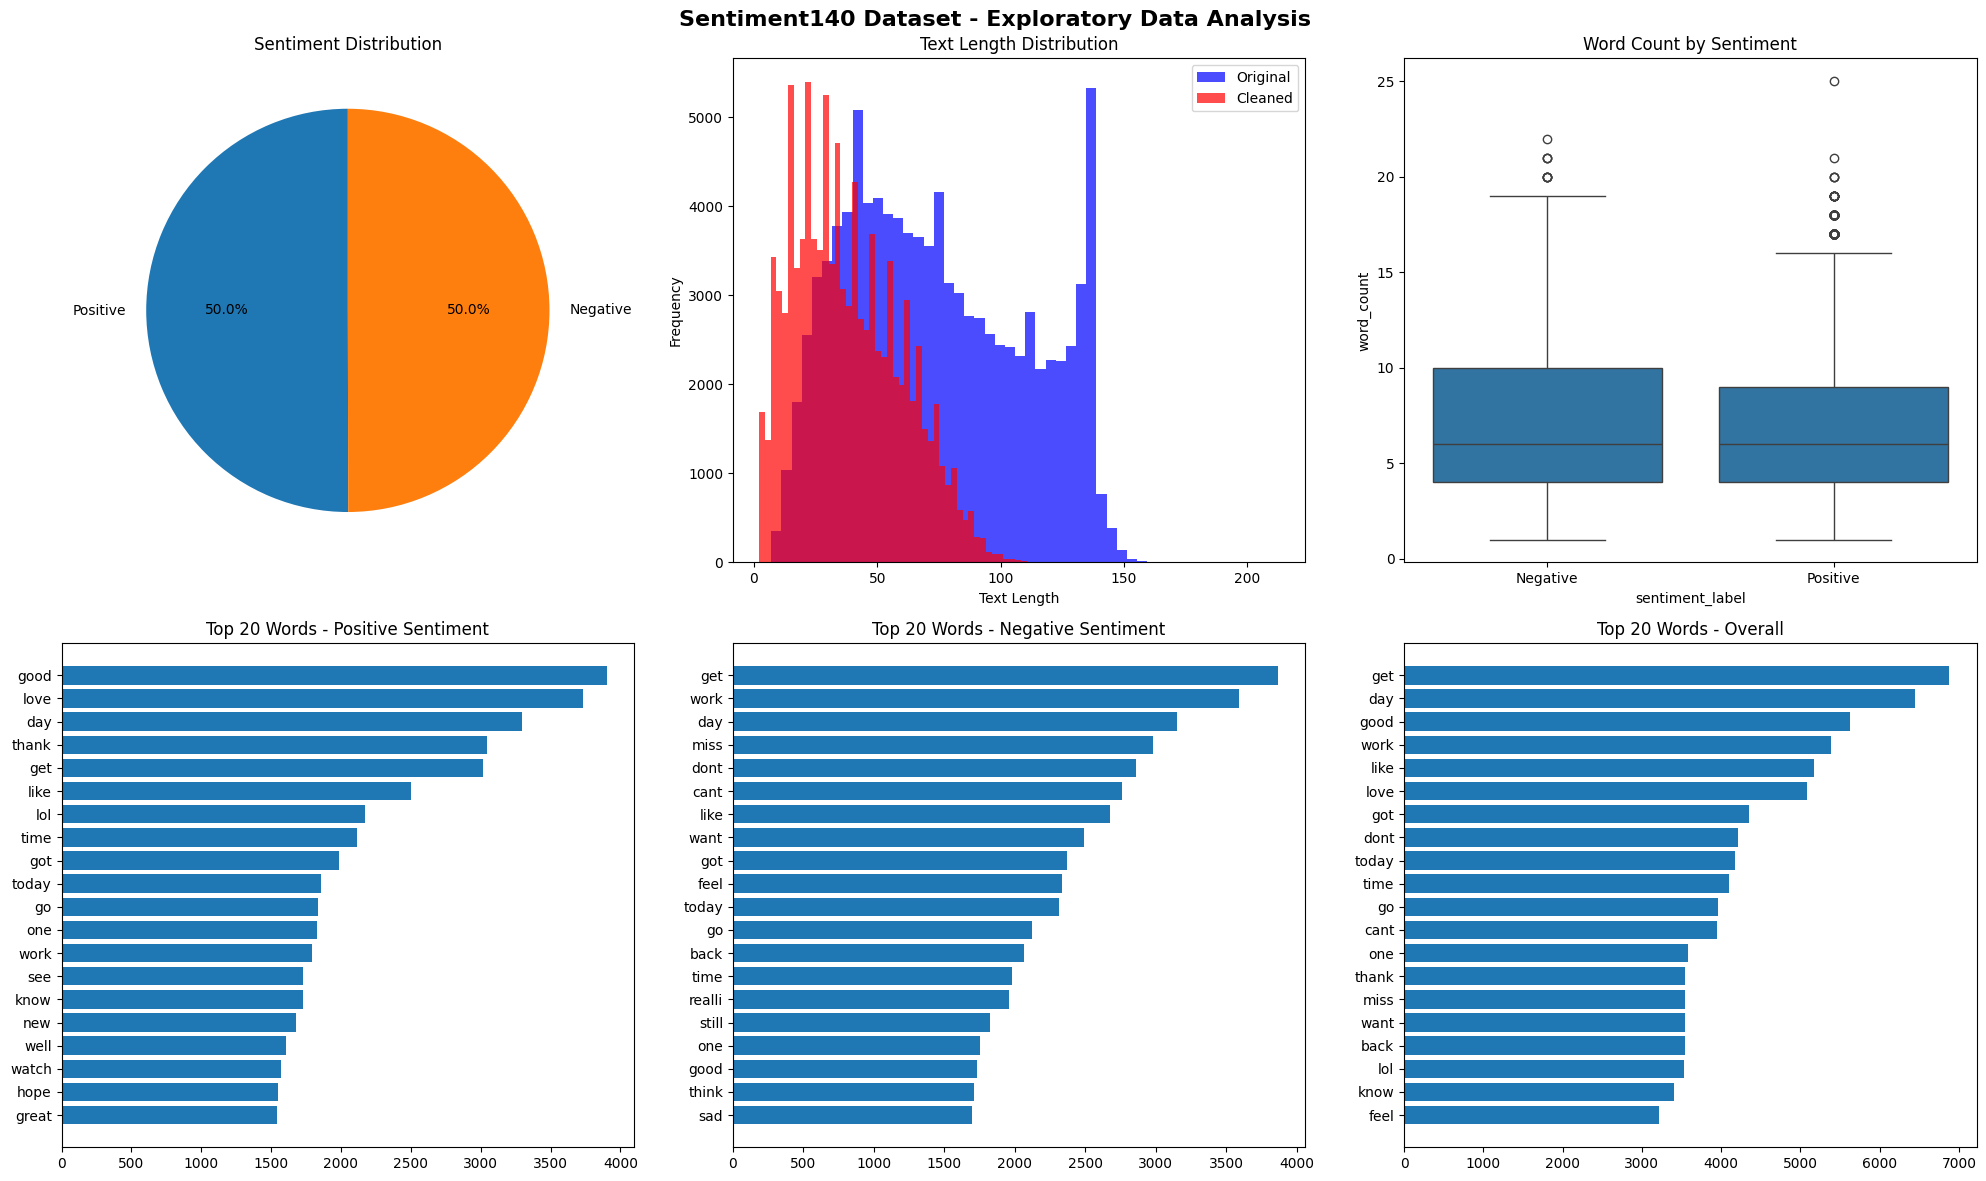

Generating Word Clouds...


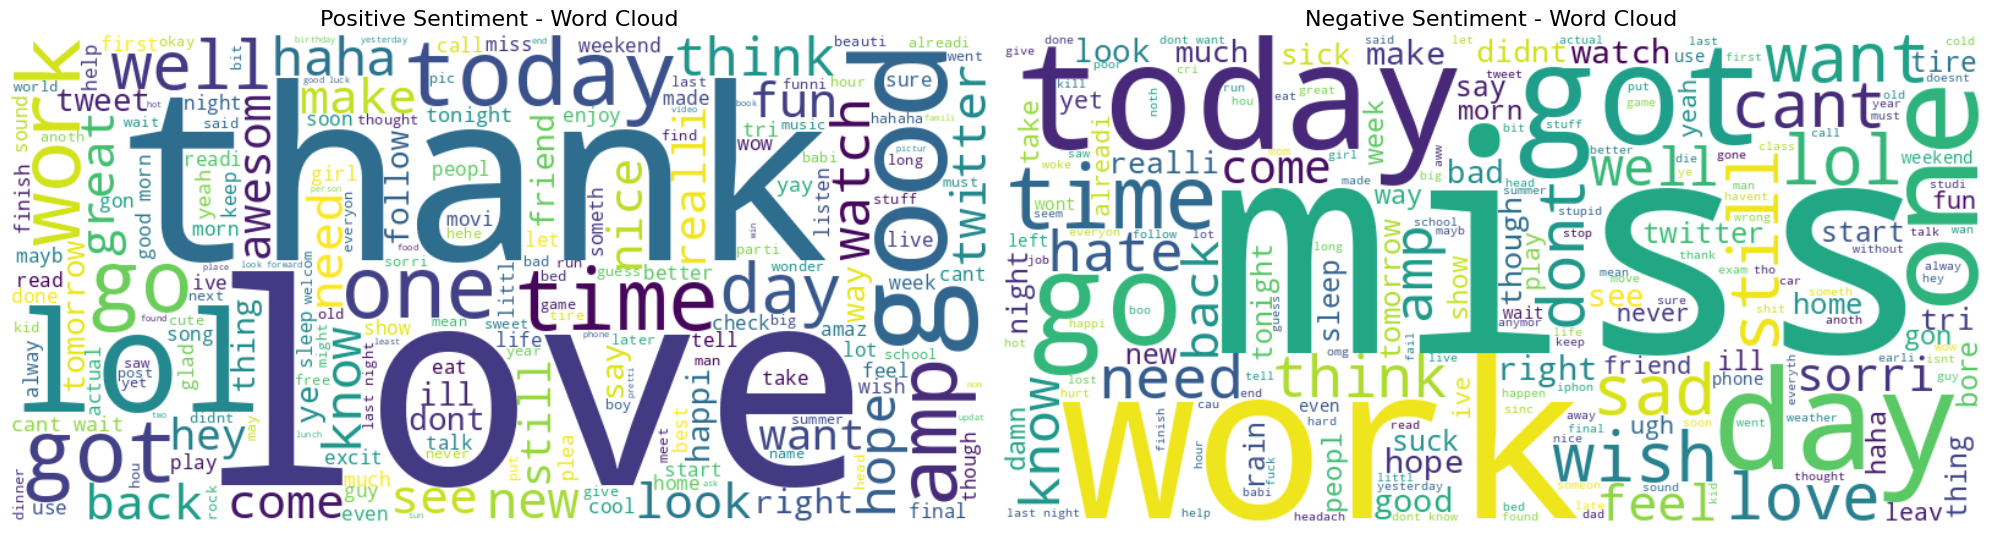

Performing N-gram Analysis...


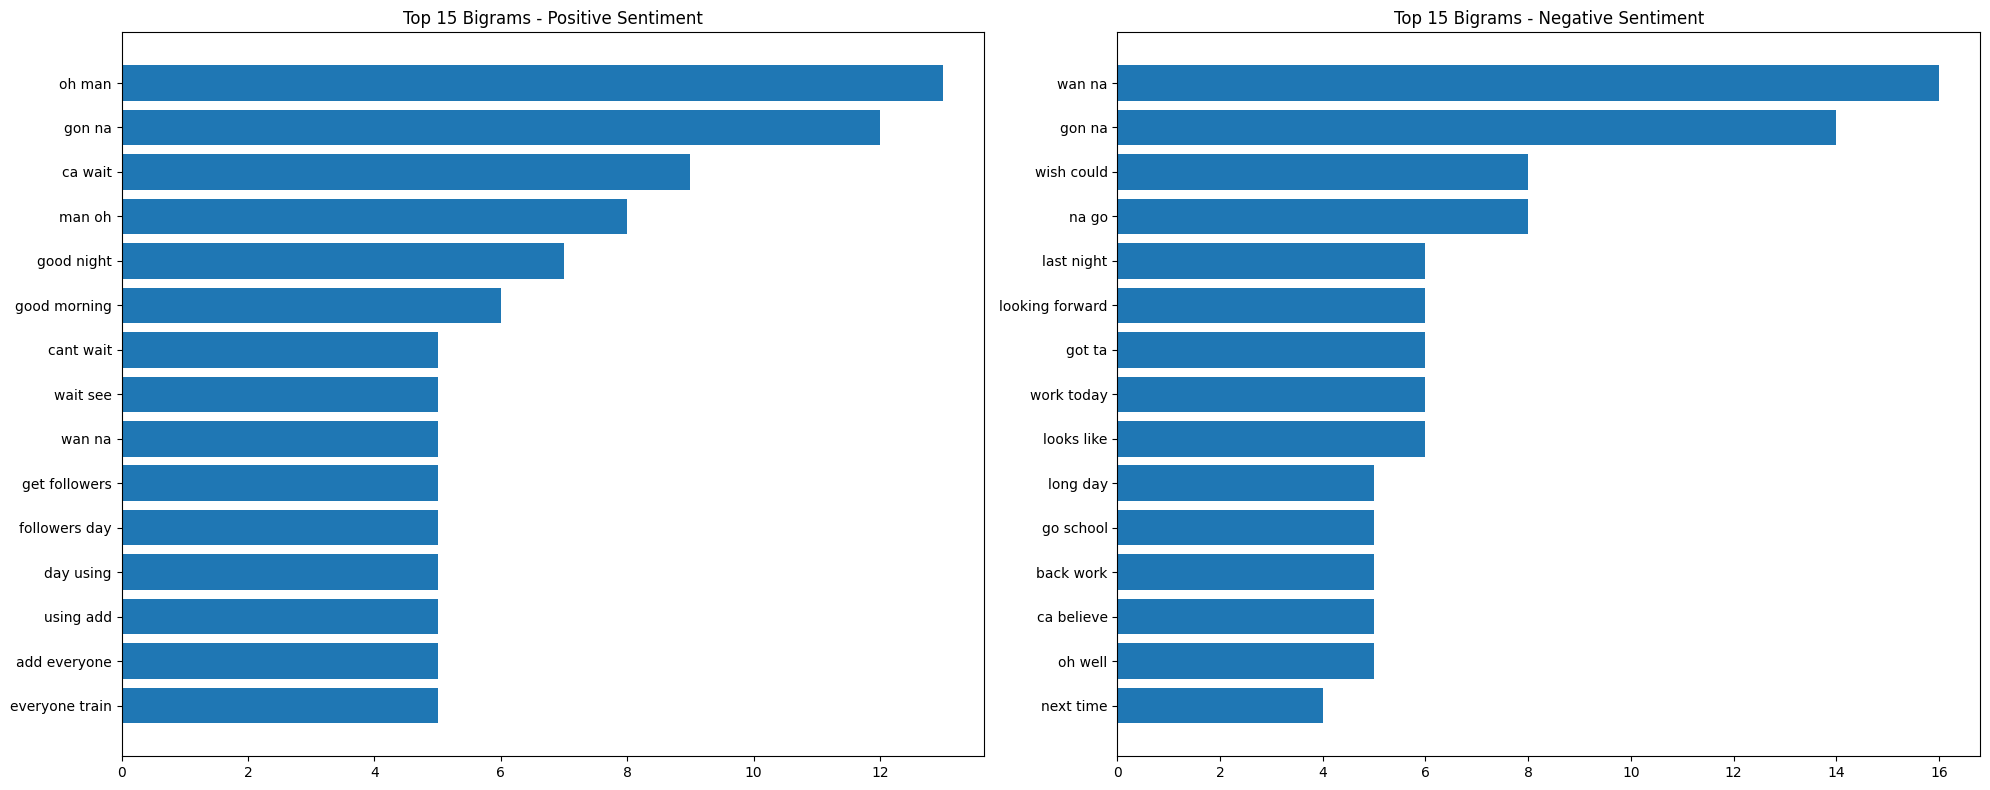


STEP 4: MODEL BUILDING
Training set size: 79497
Test set size: 19875
Extracting TF-IDF features...
TF-IDF feature matrix shape: (79497, 5000)
Training and evaluating models...

Training SVM...


In [ ]:
# Initialize preprocessor
preprocessor = TextPreprocessor()

# Sample a subset for faster processing (you can use full dataset if needed)
print("Sampling dataset for faster processing...")
df_sample = df.sample(n=100000, random_state=42).reset_index(drop=True)

print("Applying text preprocessing...")
df_sample['cleaned_text'] = df_sample['text'].apply(lambda x: preprocessor.preprocess_text(x))

# Remove empty texts after preprocessing
df_sample = df_sample[df_sample['cleaned_text'].str.len() > 0].reset_index(drop=True)

print(f"Dataset shape after preprocessing: {df_sample.shape}")
print(f"\nExample of original vs cleaned text:")
for i in range(3):
    print(f"\nOriginal: {df_sample.iloc[i]['text']}")
    print(f"Cleaned:  {df_sample.iloc[i]['cleaned_text']}")

# =====================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# =====================================

print("\n" + "="*50)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("="*50)

# Set up the plotting style
plt.style.use('default')
fig_size = (15, 10)

# Create subplots for EDA
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Sentiment140 Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Class Distribution
axes[0, 0].pie(df_sample['sentiment_label'].value_counts().values,
               labels=df_sample['sentiment_label'].value_counts().index,
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Sentiment Distribution')

# 2. Text Length Distribution
df_sample['text_length'] = df_sample['text'].str.len()
df_sample['cleaned_text_length'] = df_sample['cleaned_text'].str.len()

axes[0, 1].hist(df_sample['text_length'], bins=50, alpha=0.7, label='Original', color='blue')
axes[0, 1].hist(df_sample['cleaned_text_length'], bins=50, alpha=0.7, label='Cleaned', color='red')
axes[0, 1].set_xlabel('Text Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Text Length Distribution')
axes[0, 1].legend()

# 3. Word Count Distribution
df_sample['word_count'] = df_sample['cleaned_text'].str.split().str.len()
sns.boxplot(data=df_sample, x='sentiment_label', y='word_count', ax=axes[0, 2])
axes[0, 2].set_title('Word Count by Sentiment')

# 4. Most Common Words - Positive Sentiment
positive_texts = ' '.join(df_sample[df_sample['sentiment'] == 1]['cleaned_text'])
positive_words = positive_texts.split()
positive_freq = Counter(positive_words).most_common(20)

pos_words, pos_counts = zip(*positive_freq)
axes[1, 0].barh(range(len(pos_words)), pos_counts)
axes[1, 0].set_yticks(range(len(pos_words)))
axes[1, 0].set_yticklabels(pos_words)
axes[1, 0].set_title('Top 20 Words - Positive Sentiment')
axes[1, 0].invert_yaxis()

# 5. Most Common Words - Negative Sentiment
negative_texts = ' '.join(df_sample[df_sample['sentiment'] == 0]['cleaned_text'])
negative_words = negative_texts.split()
negative_freq = Counter(negative_words).most_common(20)

neg_words, neg_counts = zip(*negative_freq)
axes[1, 1].barh(range(len(neg_words)), neg_counts)
axes[1, 1].set_yticks(range(len(neg_words)))
axes[1, 1].set_yticklabels(neg_words)
axes[1, 1].set_title('Top 20 Words - Negative Sentiment')
axes[1, 1].invert_yaxis()

# 6. Overall word frequency
all_words = (positive_texts + ' ' + negative_texts).split()
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)

axes[1, 2].barh(range(len(words)), counts)
axes[1, 2].set_yticks(range(len(words)))
axes[1, 2].set_yticklabels(words)
axes[1, 2].set_title('Top 20 Words - Overall')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

# Word Clouds
print("Generating Word Clouds...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive sentiment word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Positive Sentiment - Word Cloud', fontsize=16)
axes[0].axis('off')

# Negative sentiment word cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Negative Sentiment - Word Cloud', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# N-gram Analysis
print("Performing N-gram Analysis...")

def get_ngrams(text, n=2):
    """Extract n-grams from text"""
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]

# Bigrams for positive and negative sentiments
pos_bigrams = []
neg_bigrams = []

for text in df_sample[df_sample['sentiment'] == 1]['text'].head(1000):
    pos_bigrams.extend(get_ngrams(text, 2))

for text in df_sample[df_sample['sentiment'] == 0]['text'].head(1000):
    neg_bigrams.extend(get_ngrams(text, 2))

# Most common bigrams
pos_bigram_freq = Counter(pos_bigrams).most_common(15)
neg_bigram_freq = Counter(neg_bigrams).most_common(15)

# Plot bigrams
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive bigrams
pos_bigrams_words, pos_bigrams_counts = zip(*pos_bigram_freq)
axes[0].barh(range(len(pos_bigrams_words)), pos_bigrams_counts)
axes[0].set_yticks(range(len(pos_bigrams_words)))
axes[0].set_yticklabels(pos_bigrams_words)
axes[0].set_title('Top 15 Bigrams - Positive Sentiment')
axes[0].invert_yaxis()

# Negative bigrams
neg_bigrams_words, neg_bigrams_counts = zip(*neg_bigram_freq)
axes[1].barh(range(len(neg_bigrams_words)), neg_bigrams_counts)
axes[1].set_yticks(range(len(neg_bigrams_words)))
axes[1].set_yticklabels(neg_bigrams_words)
axes[1].set_title('Top 15 Bigrams - Negative Sentiment')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# =====================================
# STEP 4: MODEL BUILDING
# =====================================

print("\n" + "="*50)
print("STEP 4: MODEL BUILDING")
print("="*50)

# Prepare data for modeling
X = df_sample['cleaned_text']
y = df_sample['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Feature Extraction - TF-IDF
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Model Training and Evaluation
models = {
    #'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    #'Naive Bayes': MultinomialNB(),
    #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

results = {}

print("Training and evaluating models...")
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred,
        'model': model
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

# Display detailed results
print("\n" + "="*50)
print("DETAILED MODEL EVALUATION")
print("="*50)

for name, result in results.items():
    print(f"\n{name}:")
    print("Classification Report:")
    print(classification_report(y_test, result['predictions'],
                              target_names=['Negative', 'Positive']))

# Plot model comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
f1_scores = [results[name]['f1_score'] for name in model_names]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
axes[0].bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange'])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# F1-Score comparison
axes[1].bar(model_names, f1_scores, color=['blue', 'green', 'red', 'orange'])
axes[1].set_title('Model F1-Score Comparison')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion Matrix for best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model_pred = results[best_model_name]['predictions']

print(f"\nConfusion Matrix for Best Model ({best_model_name}):")
cm = confusion_matrix(y_test, best_model_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance (for models that support it)
if best_model_name in ['Logistic Regression', 'Random Forest']:
    print(f"\nTop 20 Most Important Features ({best_model_name}):")

    if best_model_name == 'Logistic Regression':
        feature_importance = results[best_model_name]['model'].coef_[0]
    else:  # Random Forest
        feature_importance = results[best_model_name]['model'].feature_importances_

    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get top positive and negative features
    top_indices = np.argsort(np.abs(feature_importance))[-20:]
    top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
    top_features.sort(key=lambda x: x[1], reverse=True)

    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")

# Sample predictions
print(f"\nSample Predictions using {best_model_name}:")
sample_texts = [
    "I love this movie, it's amazing!",
    "This is terrible, I hate it",
    "The weather is okay today",
    "Feeling great and happy!",
    "This is the worst day ever"
]

for text in sample_texts:
    # Preprocess the text
    cleaned = preprocessor.preprocess_text(text)
    # Transform using TF-IDF
    text_tfidf = tfidf_vectorizer.transform([cleaned])
    # Make prediction
    prediction = results[best_model_name]['model'].predict(text_tfidf)[0]
    probability = results[best_model_name]['model'].predict_proba(text_tfidf)[0]

    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = max(probability)

    print(f"Text: '{text}'")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.3f})")
    print("-" * 50)


print("\n" + "="*50)
print("SENTIMENT ANALYSIS PIPELINE COMPLETED!")
print("="*50)
print(f"\nBest performing model: {best_model_name}")
print(f"Best F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")